In [339]:
import torch
import pandas as pd
import numpy as np
import os
import torch.utils
import torchvision.transforms
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
from PIL import ImageDraw, Image
%matplotlib inline

torch.set_printoptions(threshold=1000)

In [340]:
Dataset_dir = "../Cyclist_Detection/Dataset"

In [254]:
#Writing our Dataset class
class YoloPtDataset(torch.utils.data.Dataset):
    """Dataset with tensor format images and Yolo format labels"""

    def __init__(self,root_dir,transform=None):
        try:
            self.paths = pd.read_csv(os.path.join(root_dir,"src","src.csv"))
            self.paths.values.astype(str)
        except:
            raise ValueError("The directory doesn't have a src file with the paths to all the images")

        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label_path = self.paths.iloc[idx,1:].values

        return torch.load(img_path),torch.load(label_path)

In [255]:
data = YoloPtDataset(Dataset_dir)

In [267]:
data[10]

(tensor([[[26, 25, 24,  ..., 25, 24, 24],
          [26, 26, 25,  ..., 23, 22, 22],
          [27, 27, 27,  ..., 25, 25, 25],
          ...,
          [42, 42, 43,  ..., 20, 20, 20],
          [42, 43, 43,  ..., 20, 20, 20],
          [43, 43, 43,  ..., 20, 20, 20]],
 
         [[34, 33, 32,  ..., 27, 26, 26],
          [34, 34, 33,  ..., 25, 24, 24],
          [35, 35, 35,  ..., 27, 27, 27],
          ...,
          [50, 50, 51,  ..., 25, 25, 25],
          [50, 51, 51,  ..., 25, 25, 25],
          [51, 51, 51,  ..., 25, 25, 25]],
 
         [[23, 22, 21,  ..., 16, 15, 15],
          [23, 23, 22,  ..., 14, 13, 13],
          [24, 24, 24,  ..., 16, 16, 16],
          ...,
          [39, 39, 40,  ..., 19, 19, 19],
          [39, 40, 40,  ..., 19, 19, 19],
          [40, 40, 40,  ..., 19, 19, 19]]], dtype=torch.uint8),
 tensor([[0.0000, 0.5037, 0.4292, 0.0142, 0.0830],
         [0.0000, 0.4138, 0.4321, 0.0142, 0.0752]]))

In [295]:
temp_img, temp_label = data[10]

In [301]:
data[10][1]

tensor([[0.0000, 0.5037, 0.4292, 0.0142, 0.0830],
        [0.0000, 0.4138, 0.4321, 0.0142, 0.0752]])

In [305]:
temp4 = temp_label[0]
print(temp4)

tensor([0.0000, 0.5037, 0.4292, 0.0142, 0.0830])


In [281]:
temp_img.size()[1:3]

torch.Size([1024, 2048])

In [344]:
def yolo_to_xy(yolo,resolution):
    xy = []
    x_cent = float(yolo[1]*resolution[1])
    y_cent = float(yolo[2]*resolution[0])
    width = float(yolo[3]*resolution[1])
    height = float(yolo[4]*resolution[0])
    xy.append(x_cent-(width/2))
    xy.append(y_cent-(height/2))
    xy.append(x_cent+(width/2))
    xy.append(y_cent+(height/2))
    return xy

In [347]:
def Display_yolo(img,label):

    resolution = img.size()[1:3]
    trans = torchvision.transforms.ToPILImage()
    img = trans(img)
    draw = ImageDraw.Draw(img)


    #Re-calculates the yolo format to top-left and bottom right points
    for i in range(len(label)):
        draw.rectangle(yolo_to_xy(label[i],resolution))


    out = Image.alpha_composite(img,draw)
    out.show()

In [348]:
Display_yolo(data[1][0],data[1][1])

AttributeError: 'ImageDraw' object has no attribute 'load'

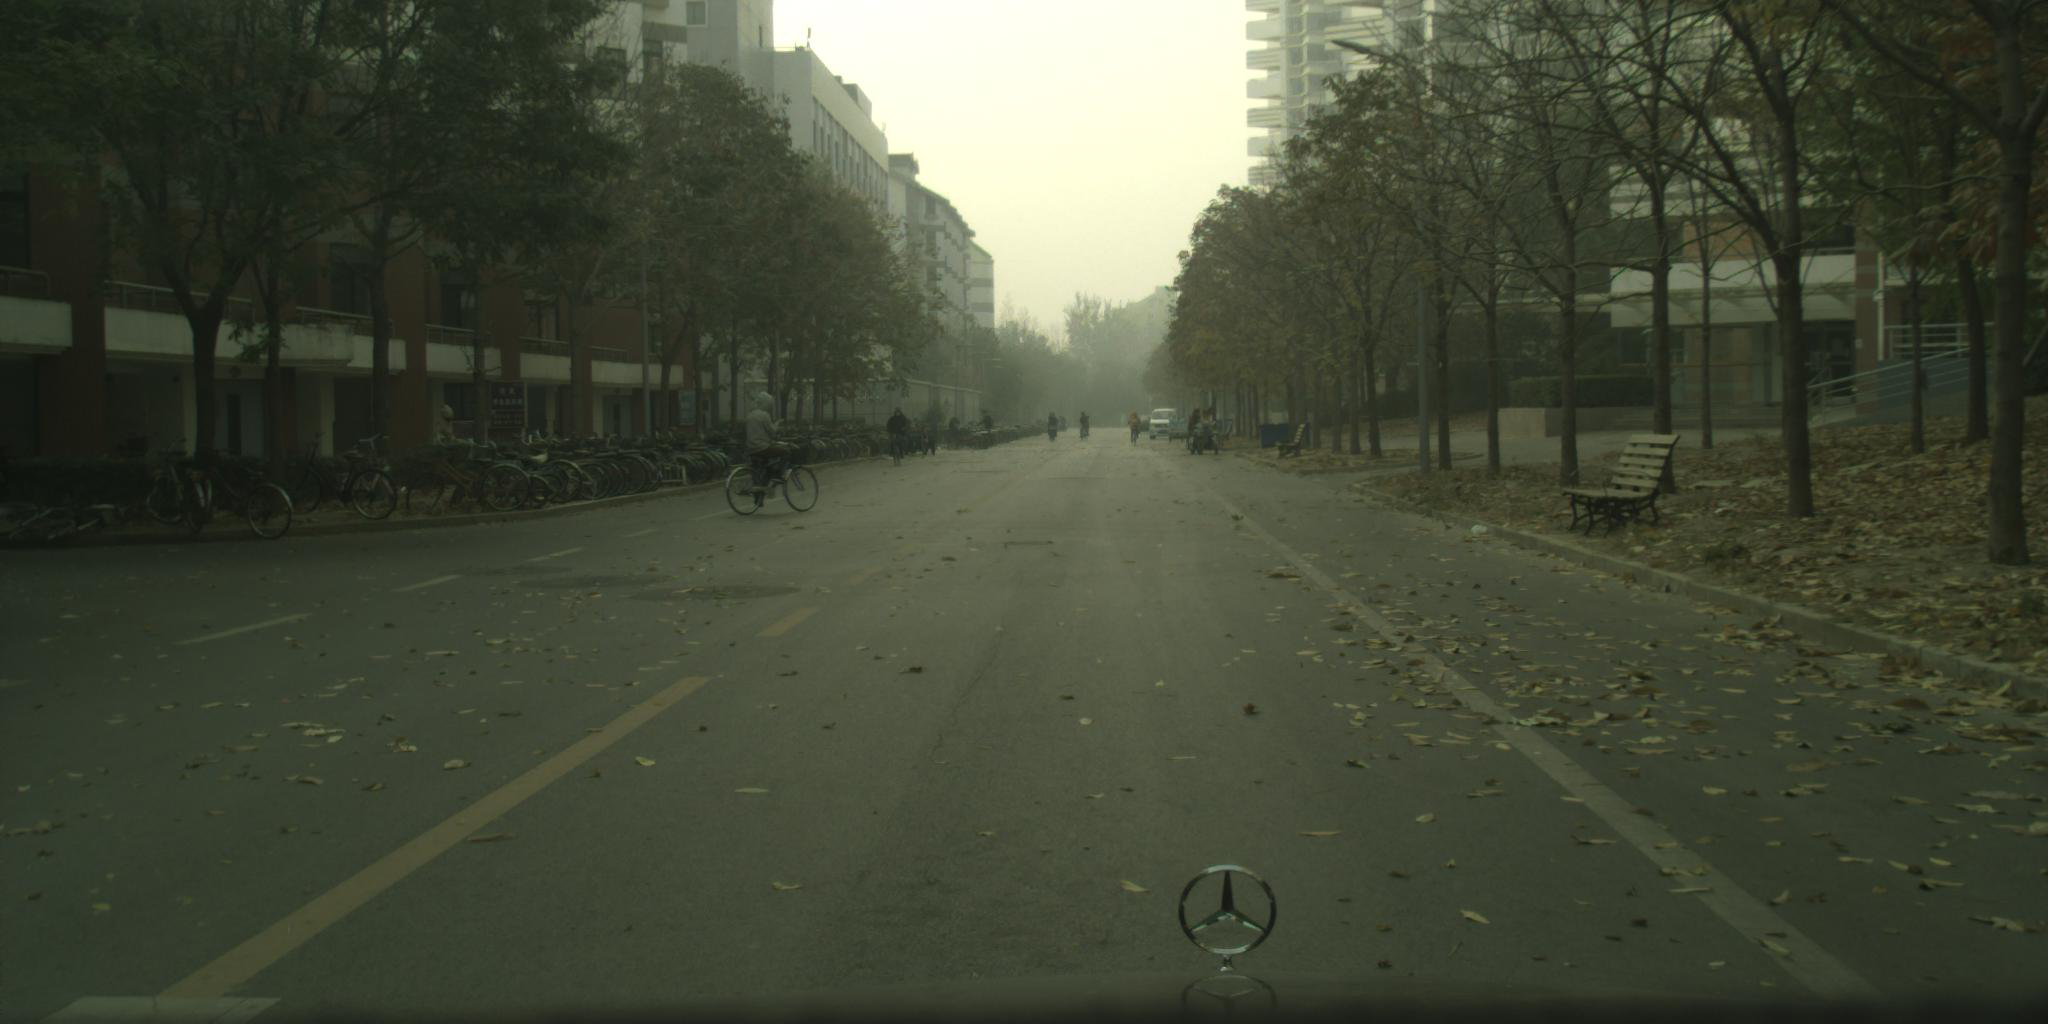

In [327]:
temp_trans = torchvision.transforms.ToPILImage()
temp_trans(data[1][0])

In [256]:
dataloader = torch.utils.data.DataLoader(data,batch_size=4,shuffle=True)

In [259]:
temp_img, temp_labels = next(iter(dataloader))

RuntimeError: stack expects each tensor to be equal size, but got [3, 5] at entry 0 and [0, 5] at entry 1